In [4]:
# %% Initial imports
import filteredPowerSpectralDensity as filtPowSpectr
from neurolib.models.pheno_hopf import PhenoHopfModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils import paths
from petTOAD_setup import *


# %% Define functions
# Define the evaluation function
def evaluate(traj):
    model = search.getModelFromTraj(traj)
    bold_list = []

    model.randomICs()
    model.run(chunkwise=True, chunksize=60000, append=True)
    # skip the first 180 secs to "warm up" the timeseries
    ts = model.outputs.x[:, 18000::300]
    t = model.outputs.t[18000::300]
    ts_filt = BOLDFilters.BandPassFilter(ts)
    bold_list.append(ts_filt)

    result_dict = {}
    result_dict["BOLD"] = np.array(bold_list).squeeze()
    result_dict["t"] = t

    search.saveToPypet(result_dict, traj)

# Define the parametere space to explore
parameters = ParameterSpace(
    {
        "a": [np.ones(90) * -0.02 + i for i in np.linspace(-0.05, 0.10, 5)],
    },
    kind="grid",
)


# Set the simulation directory for the group
EXPL_DIR = RES_DIR / "exploratory"
if not Path.exists(EXPL_DIR):
    Path.mkdir(EXPL_DIR)
# Set the directory where to save results
paths.HDF_DIR = str(EXPL_DIR)

#%%
# Get the timeseries for the HC group
group_HC, timeseries_HC = get_group_ts_for_freqs(HC, all_fMRI_clean)


# Set if the model has delay
delay = False
if not delay:
    Dmat_dummy = np.zeros_like(sc)
    Dmat = Dmat_dummy
else:
    pass
# Initialize the model (neurolib wants a Dmat to initialize the mode,
# so we gave it an empty Dmat, which we also later cancel by setting it to None)
model = PhenoHopfModel(Cmat=sc, Dmat=Dmat)
model.params["Dmat"] = None if not delay else Dmat
# Empirical fmri is 193 timepoints at TR=3s (9.65 min) + 3 min of initial warm up of the timeseries
model.params["duration"] = 12.65 * 60 * 1000
model.params["signalV"] = 0
model.params["dt"] = 0.1
model.params["sampling_dt"] = 10.0
model.params["sigma"] = 0.02
model.params["K_gl"] = 1.9  # Set this to the best G previously found!!!!

f_diff = filtPowSpectr.filtPowSpetraMultipleSubjects(timeseries_HC, TR)
f_diff[np.where(f_diff == 0)] = np.mean(f_diff[np.where(f_diff != 0)])
model.params["w"] = 2 * np.pi * f_diff
#Initialize the search
search = BoxSearch(
        model=model,
        evalFunction=evaluate,
        parameterSpace=parameters,
        filename='prova.hdf',
    )
search.run(chunkwise=True, chunksize=60000, append=True)


# %%


filtPowSpectraMultipleSubjects: subject 1 (of 154)
filtPowSpectraMultipleSubjects: subject 2 (of 154)
filtPowSpectraMultipleSubjects: subject 3 (of 154)
filtPowSpectraMultipleSubjects: subject 4 (of 154)
filtPowSpectraMultipleSubjects: subject 5 (of 154)
filtPowSpectraMultipleSubjects: subject 6 (of 154)
filtPowSpectraMultipleSubjects: subject 7 (of 154)
filtPowSpectraMultipleSubjects: subject 8 (of 154)
filtPowSpectraMultipleSubjects: subject 9 (of 154)
filtPowSpectraMultipleSubjects: subject 10 (of 154)
filtPowSpectraMultipleSubjects: subject 11 (of 154)
filtPowSpectraMultipleSubjects: subject 12 (of 154)
filtPowSpectraMultipleSubjects: subject 13 (of 154)
filtPowSpectraMultipleSubjects: subject 14 (of 154)
filtPowSpectraMultipleSubjects: subject 15 (of 154)
filtPowSpectraMultipleSubjects: subject 16 (of 154)
filtPowSpectraMultipleSubjects: subject 17 (of 154)
filtPowSpectraMultipleSubjects: subject 18 (of 154)
filtPowSpectraMultipleSubjects: subject 19 (of 154)
filtPowSpectraMultipl

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/home/riccardo/petTOAD/results/exploratory/prova.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 5
MainProcess root INFO     BoxSearch: Environment initialized.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-06-21-13H-21M-08S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2023-06-21-13H-21M-08S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results

In [5]:
df = search.loadResults()

MainProcess root INFO     Loading results from /home/riccardo/petTOAD/results/exploratory/prova.hdf
MainProcess root INFO     Analyzing trajectory results-2023-06-21-13H-21M-08S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/home/riccardo/petTOAD/results/exploratory/prova.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2023-06-21-13H-21M-08S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 5/5 [00:00<00:00, 206.69it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 5/5

Text(200000, 0.06, 'a = 0.08')

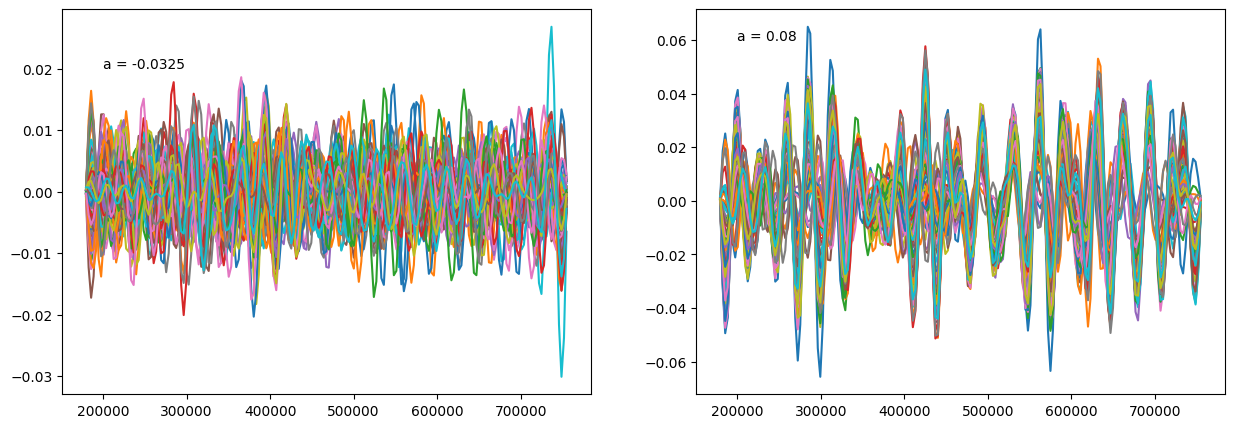

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import neurolib.utils.functions as func

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(search.dfResults['t'][0], search.dfResults['BOLD'][1].T);
plt.annotate(f"a = {search.dfResults['a'][1][0]}", xy=(200000, 0.02))
plt.subplot(122)
plt.plot(search.dfResults['t'][0], search.dfResults['BOLD'][4].T);
plt.annotate(f"a = {search.dfResults['a'][4][0]}", xy=(200000, 0.06))

-0.0325


[0.3202485892654221,
 0.2491911037956159,
 0.37273838681074606,
 0.4276312518306081,
 0.5008970053927218]

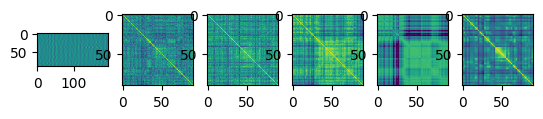

In [124]:
import scipy.io as sio

res = sio.loadmat(RES_DIR / 'model_simulations' / 'HC_noWMH' / 'group_stats.mat')
fc = res['fc']
plt.subplot(161)
plt.imshow(np.arctanh(search.dfResults['BOLD'][0]))
plt.subplot(162)
plt.imshow(func.fc(search.dfResults['BOLD'][1]))
plt.subplot(163)
plt.imshow(func.fc(search.dfResults['BOLD'][2]))
plt.subplot(164)
plt.imshow(func.fc(search.dfResults['BOLD'][3]))
plt.subplot(165)
plt.imshow(func.fc(search.dfResults['BOLD'][4]), vmin=0, vmax=1.4)
plt.subplot(166)
plt.imshow(fc)
print(search.dfResults['a'][1][0])
[func.matrix_correlation(func.fc(search.dfResults['BOLD'][i]), fc) for i in range(5)]

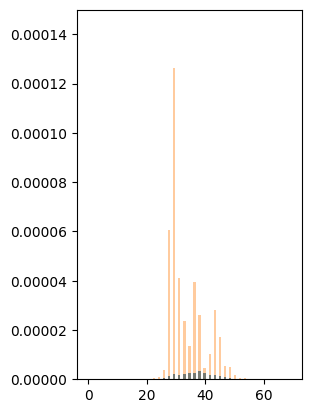

In [92]:
pow_spec1 = func.getMeanPowerSpectrum(search.dfResults['BOLD'][0], 3)
pow_spec2 = func.getMeanPowerSpectrum(search.dfResults['BOLD'][4], 3)
plt.subplot(121)
plt.bar(pow_spec1[0], pow_spec1[1]);
plt.ylim(0, 1.5*10e-5)
plt.bar(pow_spec2[0], pow_spec2[1], alpha = 0.4);